In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# set variables
# main_folder = './input/celeba-dataset/'
main_folder = 'celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'
EXAMPLE_PIC = images_folder + '000506.jpg'
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 32 # 64 128 256 等
# 若有較大的記憶體 可以批量大一些 準確率或許會提高些 可以改善overfitting
NUM_EPOCHS = 10

In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [4]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

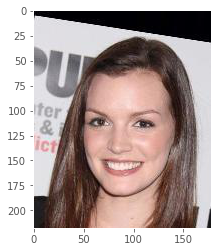

In [5]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

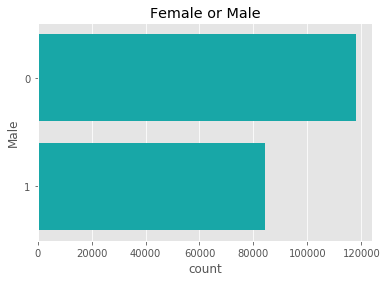

In [6]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [7]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [9]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [10]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    
    return x

In [11]:
def generate_df(partition, attr, num_samples):
    '''
    partition
    0 -> train
    1 -> validation
    2 -> test
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition)& (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,df_par_attr[(df_par_attr['partition'] == partition)& (df_par_attr[attr] == 1)].sample(int(num_samples/2))])
    # read data
    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 218, 178, 3) # (20000, 1, 218, 178, 3) reshape ==>(20000, 218, 178, 3)
    y_ = np_utils.to_categorical(df_[attr],2)
    return x_, y_

In [12]:
x_train,y_train = generate_df(0,'Male',20)

In [13]:
x_train.shape

(20, 218, 178, 3)

In [14]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
num_samples = 10
partition = 0 # train
attr = 'Male'

In [16]:
# 抽樣
df_0 = df_par_attr[(df_par_attr['partition'] == partition)
                        & (df_par_attr[attr] == 0)].sample(int(num_samples/2))

In [17]:
df_0.shape

(5, 2)

In [18]:
df_0

,partition,Male
image_id,,
010604.jpg,0,0
112500.jpg,0,0
055585.jpg,0,0
041183.jpg,0,0
098548.jpg,0,0


In [19]:
df_1 = df_par_attr[(df_par_attr['partition'] == partition)
& (df_par_attr[attr] == 1)].sample(int(num_samples/2))

In [20]:
df_1

,partition,Male
image_id,,
038321.jpg,0,1
036709.jpg,0,1
116789.jpg,0,1
148235.jpg,0,1
009288.jpg,0,1


In [21]:
df_ = pd.concat([df_0, df_1])

In [22]:
df_

,partition,Male
image_id,,
010604.jpg,0,0
112500.jpg,0,0
055585.jpg,0,0
041183.jpg,0,0
098548.jpg,0,0
038321.jpg,0,1
036709.jpg,0,1
116789.jpg,0,1
148235.jpg,0,1


In [23]:
df_ = df_par_attr[(df_par_attr['partition'] == partition)
& (df_par_attr[attr] == 0)].sample(int(num_samples/2))

In [24]:
df_ = pd.concat([df_,
df_par_attr[(df_par_attr['partition'] == partition)
& (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

In [25]:
df_

,partition,Male
image_id,,
150273.jpg,0,0
126312.jpg,0,0
139022.jpg,0,0
037567.jpg,0,0
073645.jpg,0,0
154697.jpg,0,1
074593.jpg,0,1
102375.jpg,0,1
008319.jpg,0,1


In [26]:
df_.index

Index(['150273.jpg', '126312.jpg', '139022.jpg', '037567.jpg', '073645.jpg',
       '154697.jpg', '074593.jpg', '102375.jpg', '008319.jpg', '145968.jpg'],
      dtype='object', name='image_id')

In [27]:
x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])

In [28]:
x_

array([[[[[0.6156863 , 0.3882353 , 0.34509805],
          [0.61960787, 0.39215687, 0.34509805],
          [0.62352943, 0.39607844, 0.34117648],
          ...,
          [0.80784315, 0.8509804 , 0.8745098 ],
          [0.7607843 , 0.88235295, 0.89411765],
          [0.7607843 , 0.88235295, 0.89411765]],

         [[0.6156863 , 0.3882353 , 0.34509805],
          [0.61960787, 0.39215687, 0.34509805],
          [0.62352943, 0.39607844, 0.34117648],
          ...,
          [0.80784315, 0.8509804 , 0.8745098 ],
          [0.7607843 , 0.88235295, 0.89411765],
          [0.7607843 , 0.88235295, 0.89411765]],

         [[0.6156863 , 0.3882353 , 0.34509805],
          [0.61960787, 0.39215687, 0.34509805],
          [0.62352943, 0.39607844, 0.34117648],
          ...,
          [0.8       , 0.8509804 , 0.8745098 ],
          [0.7529412 , 0.8862745 , 0.89411765],
          [0.7529412 , 0.8862745 , 0.89411765]],

         ...,

         [[0.12941177, 0.15294118, 0.14509805],
          [0.11372549,

In [29]:
x_.shape

(10, 1, 218, 178, 3)

In [30]:
x_ = x_.reshape(x_.shape[0], 218, 178, 3)

In [31]:
x_.shape

(10, 218, 178, 3)

In [32]:
y_ = np_utils.to_categorical(df_[attr],2)

In [33]:
y_

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [34]:
images_folder + df_.index[0]

'celeba-dataset/img_align_celeba/img_align_celeba/150273.jpg'

In [35]:
fname = images_folder + df_.index[0]

In [36]:
img = load_img(fname)

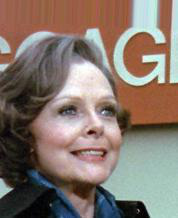

In [37]:
img

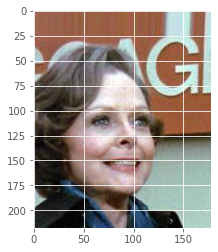

In [38]:
plt.imshow(img)

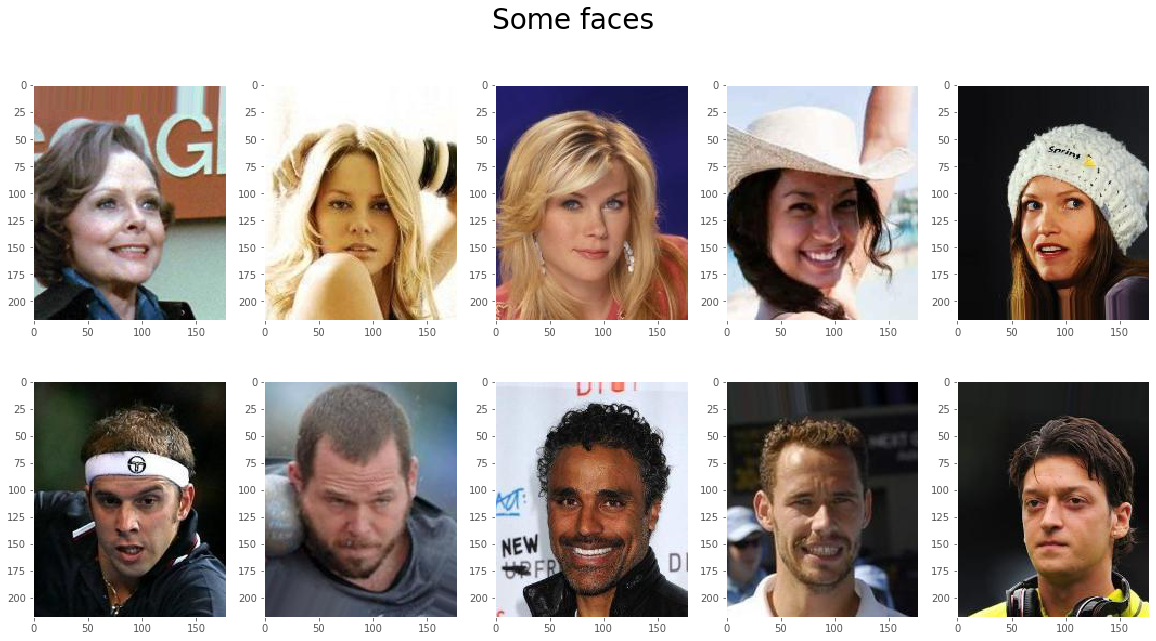

In [39]:
# plot some iamges
plt.figure(figsize=(20,10))
plt.suptitle('Some faces', fontsize=28)
for i, fname in enumerate(df_.index):
    
    
    plt.subplot(2, 5, i+1)
    plt.grid(False)
    
    img = load_img(images_folder + fname)
    x = img_to_array(img)/255.
    
    plt.imshow( x )
plt.show()

In [40]:
# Generate image generator for data augmentation
# Don't preprocess_input data here, because we want to draw those images.
datagen = ImageDataGenerator(
  # preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.5,
  horizontal_flip=True
)

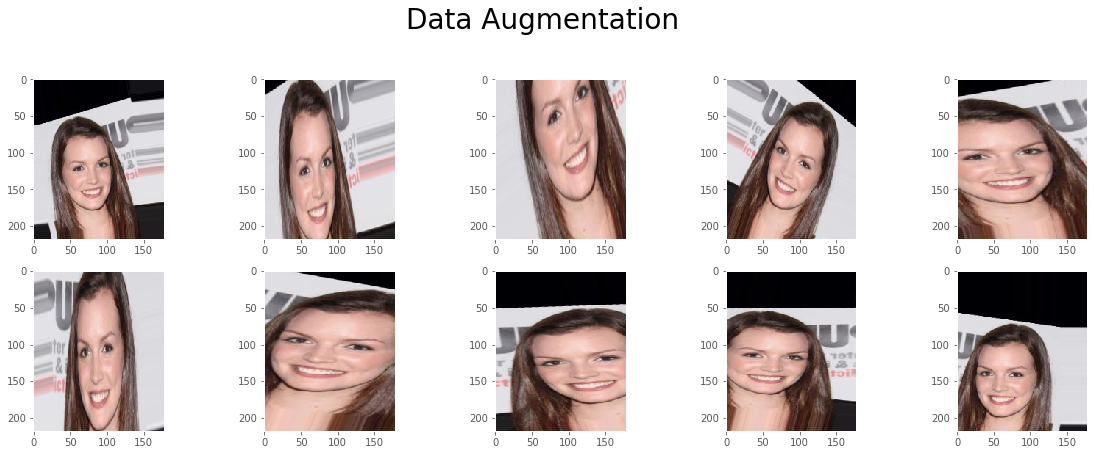

In [41]:
# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255. # 繪圖0~1 float32 0~255 需為int
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    if i == 9:
        break
    i += 1
plt.show()

In [42]:
%%time
# Train data: it takes a while to load data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)
# Train - Data Preparation - Data Augmentation with generators
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

Wall time: 38.7 s


In [43]:
# how many steps for each epoch
# 一個訓練回合，會載入多少次?(每一次載入一個batch=32)
TRAINING_SAMPLES/BATCH_SIZE

312.5

In [44]:
len(train_generator)

313

In [45]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

# 在後面的範例中並沒有(通常也不需要)對validataion做影像增強
# Validation - Data Preparation - Data Augmentation with generators
# validation set 需要批次讀入 ? 若數據量大時 需要 否則一次讀入即可
valid_datagen = ImageDataGenerator(
# preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)

In [46]:
validation_generator

In [47]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [48]:
#Adding custom Layers
m = inc_model.output
m = GlobalAveragePooling2D()(m)
m = Dense(1024, activation="relu")(m)
m = Dropout(0.5)(m)
m = Dense(512, activation="relu")(m)
predictions = Dense(2, activation="softmax")(m)

In [49]:
# creating the final model (a new one)
model = Model(inputs=inc_model.input, outputs=predictions)

In [50]:
#model summary

In [51]:
# Lock initial layers to do not be trained
for layer in model.layers[:52]:
    layer.trainable = False

In [52]:
# compile the model
# 分類交叉熵categorical_crossentropy:2個或2個以上類別用one-hot格式
# 二進制交叉熵binary_crossentropy: 輸出層以一個node表達2個類別0,1
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [53]:
#https://keras.io/models/sequential/ fit generator
# 如果我們只想保存一個最好的模型，那麼把保存文件名字固定為filepath="model.best.hdf5
# 如果要存權重 save_weights_only=True ==> filepath="weights.best.hdf5"
#
model_saved_path = 'model.best.inc.celeb_gender.hdf5'
checkpoint = ModelCheckpoint(filepath=model_saved_path,
                            monitor='val_loss', # 越小越好 monitor='val_acc' 越大越好
                            save_best_only=True,
                            mode='auto', # mode='max', mode='min'
                            verbose=1, period=1)

In [54]:
# 搭配EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
# patience=5 表示連續5次沒有改善就停止訓練

In [55]:
%%time
# Fit the model
hist = model.fit_generator(train_generator # 一次讀入一批訓練
    , validation_data = validation_generator # validate: 一次讀入一批驗證
    , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
    , epochs= 10
    , callbacks=[checkpoint, earlystop] ## 或是: [checkpoint]
    , verbose=1
)

Epoch 1/10
313/312 [==============================] - 98s 314ms/step - loss: 0.6130 - acc: 0.6611 - val_loss: 0.6309 - val_acc: 0.8545

Epoch 00001: val_loss improved from inf to 0.63087, saving model to model.best.inc.celeb_gender.hdf5
Epoch 2/10
313/312 [==============================] - 79s 251ms/step - loss: 0.4222 - acc: 0.8110 - val_loss: 0.0964 - val_acc: 0.8825

Epoch 00002: val_loss improved from 0.63087 to 0.09640, saving model to model.best.inc.celeb_gender.hdf5
Epoch 3/10
313/312 [==============================] - 79s 252ms/step - loss: 0.3358 - acc: 0.8603 - val_loss: 0.1127 - val_acc: 0.8945

Epoch 00003: val_loss did not improve from 0.09640
Epoch 4/10
313/312 [==============================] - 79s 251ms/step - loss: 0.2814 - acc: 0.8817 - val_loss: 0.0430 - val_acc: 0.8880

Epoch 00004: val_loss improved from 0.09640 to 0.04303, saving model to model.best.inc.celeb_gender.hdf5
Epoch 5/10
313/312 [==============================] - 79s 251ms/step - loss: 0.2489 - acc: 0.8

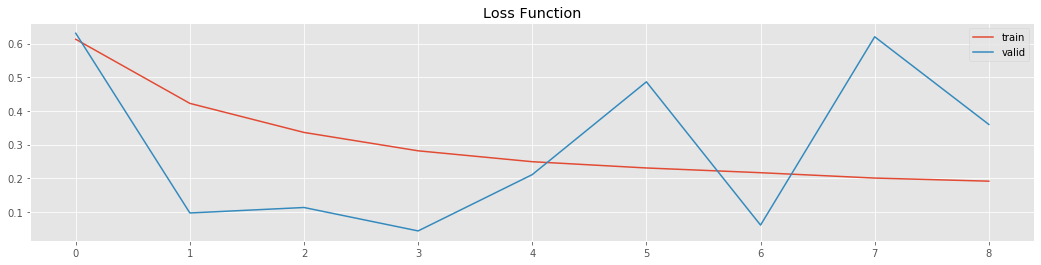

In [56]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

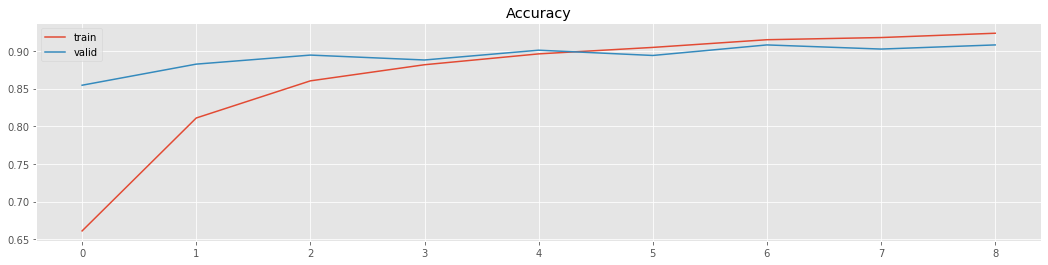

In [57]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [58]:
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

In [59]:
x_test.shape

(2000, 218, 178, 3)

In [60]:
x_test[0][0][0]

array([0.7764706 , 0.76862746, 0.77254903], dtype=float32)

In [61]:
model.evaluate(x_test, y_test)

2000/2000 [==============================] - 6s 3ms/step


[0.2724657043926418, 0.8960000276565552]

In [62]:
 model.save('model_inceptionv3_celeb_gender.h5')

In [63]:
def predict_gender(filename):
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 
                    (IMG_WIDTH,IMG_HEIGHT)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)
    return result

In [64]:
img_path = 'Jay-Chou.jpg'

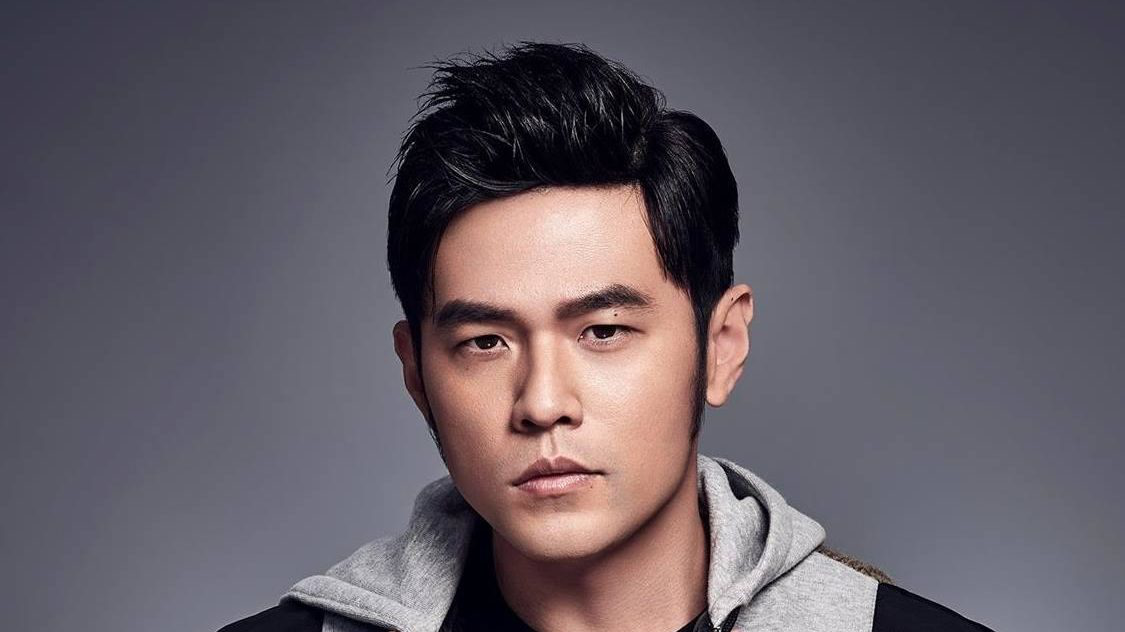

In [65]:
Image.open(img_path)

In [66]:
predict_gender(img_path)

array([[0.11526459, 0.8847354 ]], dtype=float32)